/Users/mikensubuga/opt/miniconda3/envs/mlamr39/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classifier: Logistic Regression
Accuracy: 0.6400665004156276
Confusion Matrix:
 [[  5   1   0   1]
 [  0 148   5 101]
 [  0   3 325 102]
 [  0  48 172 292]]
Classification Report:
                         precision    recall  f1-score   support

Admit to hospital ward       1.00      0.71      0.83         7
            N/A (died)       0.74      0.58      0.65       254
       Take to theatre       0.65      0.76      0.70       430
   Treat and send home       0.59      0.57      0.58       512

              accuracy                           0.64      1203
             macro avg       0.74      0.66      0.69      1203
          weighted avg       0.64      0.64      0.64      1203

------------------------------
Classifier: Random Forest
Accuracy: 0.6350789692435578
Confusion Matrix:
 [[  6   1   0   0]
 [  0 142   6 106]
 [  0   3 336  91]
 [  0  90 142 280]]
Classification Report:
                         precision    recall  f1-score   support

Admit to hospital ward       1.00

/Users/mikensubuga/opt/miniconda3/envs/mlamr39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mikensubuga/opt/miniconda3/envs/mlamr39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mikensubuga/opt/miniconda3/envs/mlamr39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

Classifier: Support Vector Machine
Accuracy: 0.5220282626766417
Confusion Matrix:
 [[  0   0   6   1]
 [  0   1 138 115]
 [  0   0 289 141]
 [  0   0 174 338]]
Classification Report:
                         precision    recall  f1-score   support

Admit to hospital ward       0.00      0.00      0.00         7
            N/A (died)       1.00      0.00      0.01       254
       Take to theatre       0.48      0.67      0.56       430
   Treat and send home       0.57      0.66      0.61       512

              accuracy                           0.52      1203
             macro avg       0.51      0.33      0.29      1203
          weighted avg       0.62      0.52      0.46      1203

------------------------------
Best Model: ('Gradient Boosting', 0.6716541978387365, 0.669738293426859, 0.6716541978387365, 0.6669899352686993, 0.9099464325240284)
               Classifier  Accuracy  Precision    Recall  F1-Score   AUC-ROC
0     Logistic Regression  0.640067   0.644028  0.640067  0.

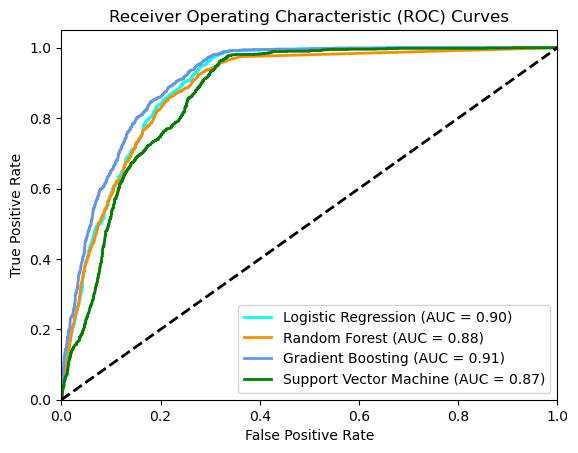

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_recall_fscore_support
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
from itertools import cycle

# Load the dataset
file_path = 'data.xlsx'
data = pd.read_excel(file_path)

# Select relevant columns
columns = ['sex', 'age', 'hours_to_hospital', 'kts', 'initialdec', 'mechofinj_str']
data = data[columns]

# Convert 'sex' to categorical
data['sex'] = data['sex'].map({1: 'Male', 2: 'Female'}).fillna('Unknown')

# Create 'age_group' from 'age'
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
labels = ['0-9yrs', '10-19yrs', '20-29yrs', '30-39yrs', '40-49yrs', '50-59yrs', '60-69yrs', '70-79yrs', '80-89yrs', '90-99yrs', '100-110yrs']
data['age_group'] = pd.cut(data['age'], bins=bins, labels=labels, right=False, include_lowest=True)

# Convert 'injury_severity' based on 'kts'
bins = [-np.inf, 10, 13, 16]
labels = ['Severe', 'Moderate', 'Mild']
data['injury_severity'] = pd.cut(data['kts'], bins=bins, labels=labels, include_lowest=True)
data['injury_severity'] = data['injury_severity'].cat.add_categories('Unknown')
data['injury_severity'] = data['injury_severity'].fillna('Unknown')

# Convert 'initial_dec' to categorical with appropriate labels
data['initialdec'] = data['initialdec'].map({
    1: 'Treat and send home',
    2: 'Take to theatre',
    3: 'N/A (died)',
    4: 'Admit to hospital ward'
}).fillna('Unknown')

# Filter out 'Send to' and 'Unknown' from 'initialdec'
data = data[~data['initialdec'].isin(['Send to', 'Unknown'])]

# Ensure no NaN values remain in categorical columns
data['age_group'] = data['age_group'].astype(str).fillna('Unknown')
data['injury_severity'] = data['injury_severity'].astype(str).fillna('Unknown')

# Select features and target variable
features = ['age_group', 'sex', 'hours_to_hospital', 'mechofinj_str']
target = 'initialdec'

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), ['hours_to_hospital']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['age_group', 'sex', 'mechofinj_str'])
    ])

# Split data into training and testing sets
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and train the pipeline for each classifier
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100),
    'Support Vector Machine': SVC(probability=True)
}

results = []
fpr_dict = {}
tpr_dict = {}
roc_auc_dict = {}

# Train and evaluate classifiers
for name, clf in classifiers.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', clf)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    
    # Compute ROC curve and ROC area for each classifier
    y_test_bin = label_binarize(y_test, classes=pipeline.classes_)
    y_pred_prob = pipeline.predict_proba(X_test)
    
    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
    roc_auc = auc(fpr, tpr)

    fpr_dict[name] = fpr
    tpr_dict[name] = tpr
    roc_auc_dict[name] = roc_auc

    results.append((name, accuracy, precision, recall, f1_score, roc_auc))
    
    print(f'Classifier: {name}')
    print('Accuracy:', accuracy)
    print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
    print('Classification Report:\n', classification_report(y_test, y_pred))
    print('-'*30)

# Determine the model with the highest accuracy
best_model = max(results, key=lambda x: x[1])
print(f'Best Model: {best_model}')

# Create a table for the results
results_df = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC'])
print(results_df)

# Plotting the ROC curves
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])

for (name, color) in zip(classifiers.keys(), colors):
    plt.plot(fpr_dict[name], tpr_dict[name], color=color, lw=2, label=f'{name} (AUC = {roc_auc_dict[name]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()


In [4]:
results_df.to_csv('results_no_kts.csv', index=False)
